In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cols = [
    "STCNTY",
    "FIPS",
    "E_TOTPOP",
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE"]

In [3]:
df = pd.read_csv("data/California.csv", usecols=cols, dtype={"FIPS":str})

In [4]:
df.head()

,STCNTY,FIPS,E_TOTPOP,E_AFAM,E_HISP,E_ASIAN,E_AIAN,E_NHPI,E_TWOMORE,E_OTHERRACE
0,6001,06001400100,3035,94,125,424,0,0,170,17
1,6001,06001400200,1983,44,163,219,6,0,211,7
2,6001,06001400300,5058,433,463,773,6,34,209,55
3,6001,06001400400,4179,278,473,418,27,0,282,6
4,6001,06001400500,4021,1101,359,387,0,0,377,0


In [5]:
df['E_WHITE'] = df['E_TOTPOP'] - df[['E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN', 'E_NHPI', 'E_TWOMORE', 'E_OTHERRACE']].sum(axis=1)

# Exposure per FIPS over time

In [6]:
exposure = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")

In [10]:
exposure = exposure[[
 'wfday', 'pm25', 'GEOID', 'smoke_pm',
       'heatday', 'coldday', 'polluted', 'smoke_pm_non_zero',
       'smoke_pm_gt_five', 'hw', 'hp', 'hwp', 'hwps', 'hs', 'hws', 'ws', 'hs5',
       'hws5', 'ws5']]

In [11]:
exposure = exposure.groupby("GEOID").sum()

In [15]:
exposure = exposure.reset_index()

In [16]:
df["FIPS"] = df["FIPS"].astype(int)

In [18]:
df = df.merge(exposure, left_on="FIPS", right_on="GEOID")

In [19]:
demographic_cols = [
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE",
    "E_WHITE",
    "E_TOTPOP"
]

In [31]:
def plot_qbar(exposure_per_category, htsp):
    # Plot the bar chart
    # ax = exposure_per_category.plot(kind='bar', figsize=(8, 5))

    # Melt the DataFrame to long format
    epc = exposure_per_category.reset_index().melt(id_vars='exposure_category',
                                            var_name='Race', value_name='Proportion')


    # Plot the bar chart using Seaborn
    plt.figure(figsize=(8, 5))
    sns.barplot(data=epc, x='exposure_category', y='Proportion', hue='Race')

    plt.title('Quantile-based demographic discretization per ' +htsp+ ' exposure level')
    plt.ylabel('Proportion of the demographic group (%)')
    plt.xlabel('Exposure level (higher is worse)')
    plt.legend(title='Year',  loc='upper left', bbox_to_anchor=(1., 1))
    plt.xticks(rotation=0)
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig("figures/qdemographics_"+htsp+".png")
    plt.show()

In [26]:
df.columns

Index(['STCNTY', 'FIPS', 'E_TOTPOP', 'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN',
       'E_NHPI', 'E_TWOMORE', 'E_OTHERRACE', 'E_WHITE', 'GEOID', 'wfday',
       'pm25', 'smoke_pm', 'heatday', 'coldday', 'polluted',
       'smoke_pm_non_zero', 'smoke_pm_gt_five', 'hw', 'hp', 'hwp', 'hwps',
       'hs', 'hws', 'ws', 'hs5', 'hws5', 'ws5', 'exposure_category'],
      dtype='object')

In [27]:
hotspots = {
     'ws':{'func':pd.cut}, 
     'hw':{'func':pd.cut}, 
     'hp':{'func':pd.qcut}, 
     'hs':{'func':pd.qcut}, 
     'hwp':{'func':pd.cut}, 
     'hws':{'func':pd.cut}, 
     'hwps':{'func':pd.qcut},
     'smoke_pm_gt_five':{'func':pd.qcut}
 }

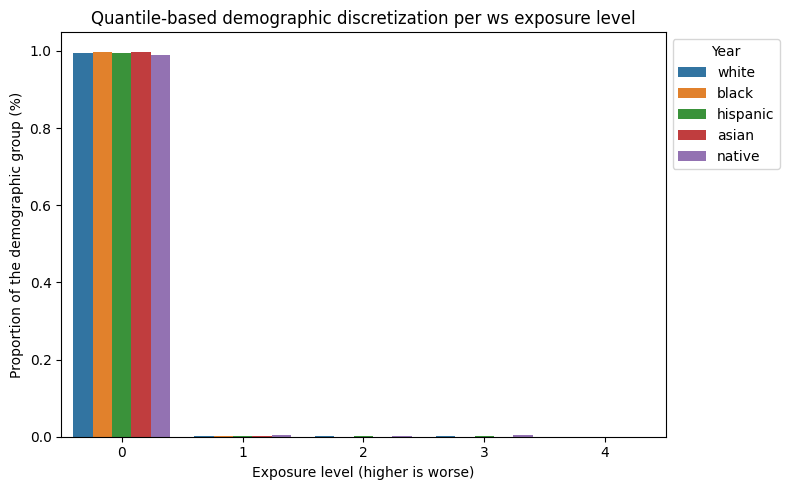

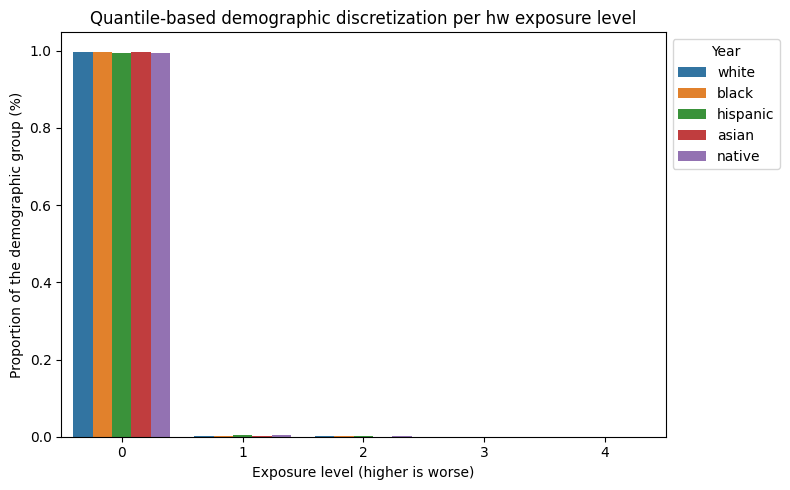

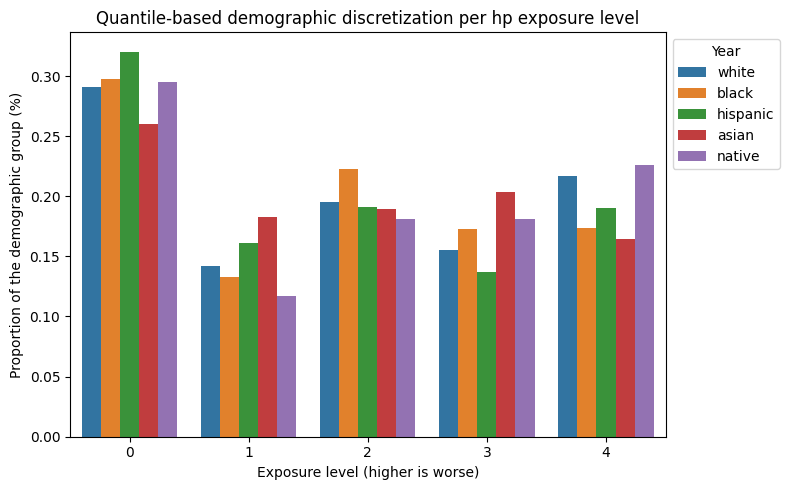

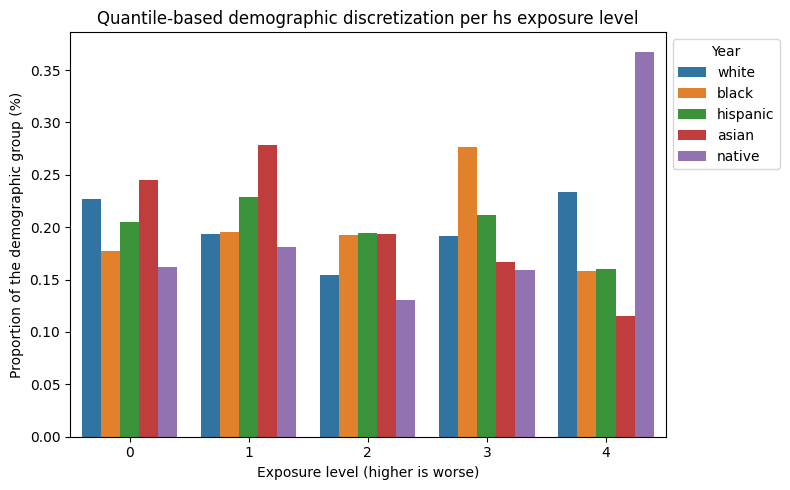

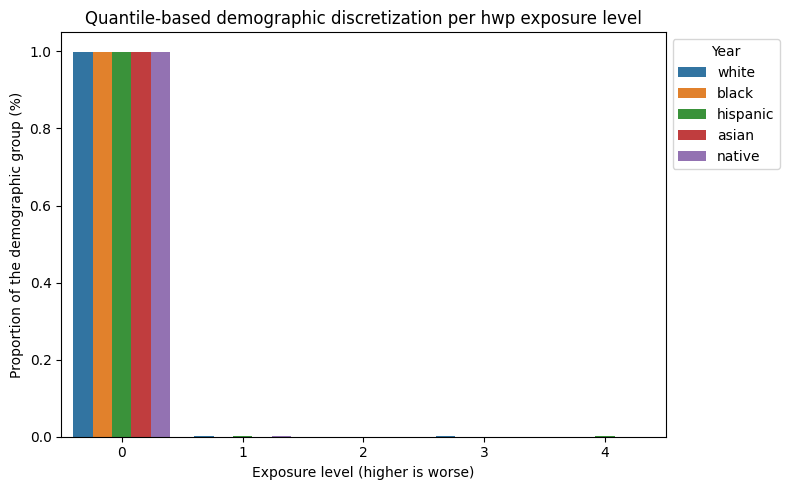

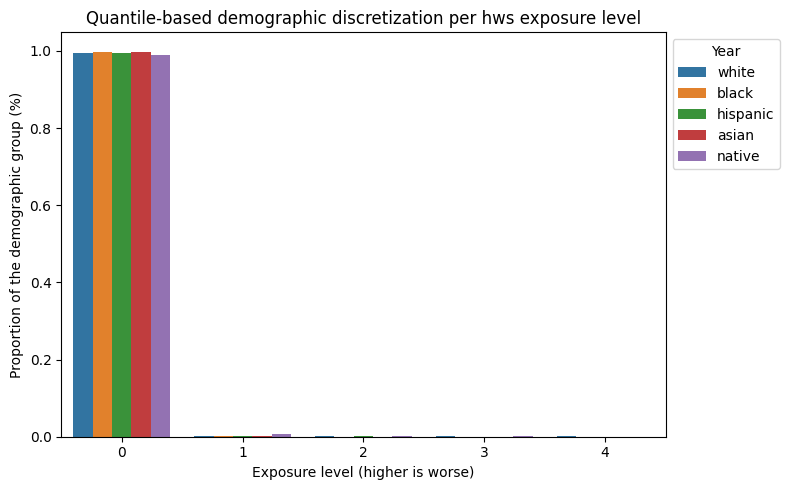

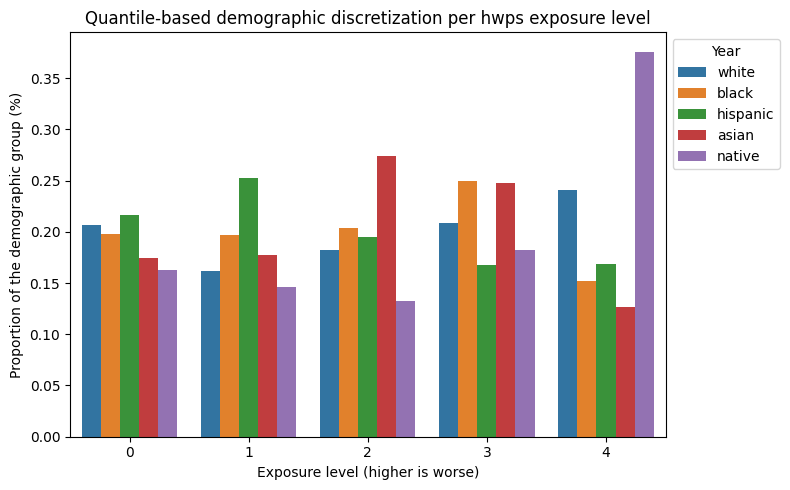

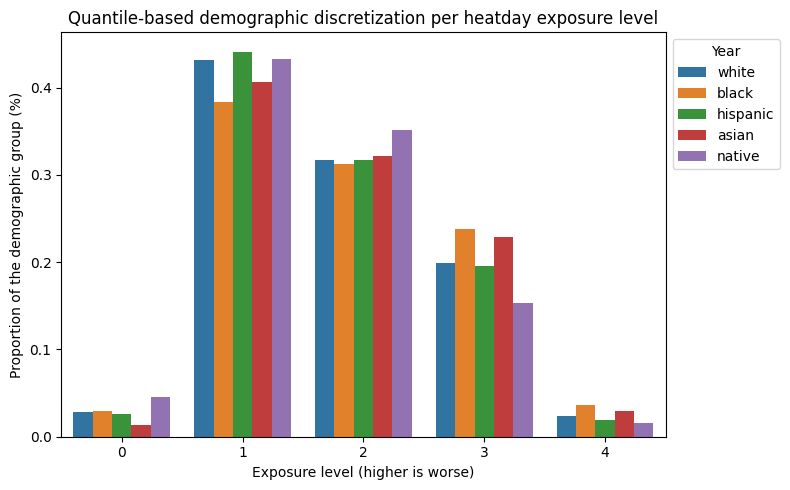

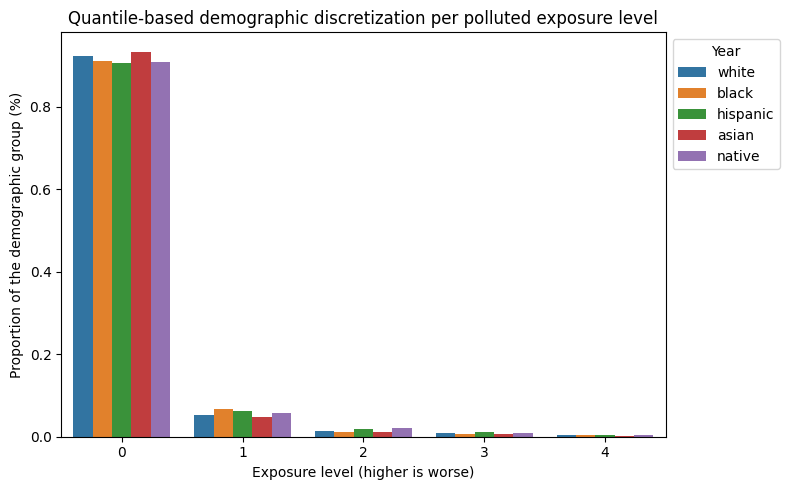

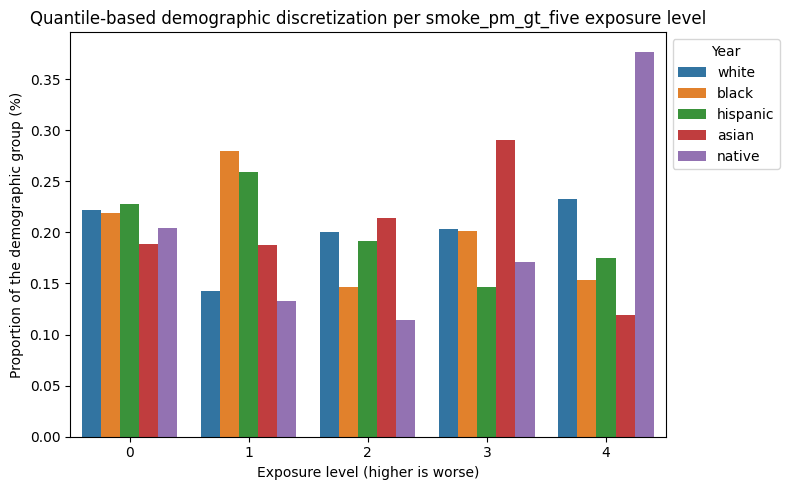

In [32]:
for hspt in hotspots.keys():
    df['exposure_category'] = hotspots[hspt]['func'](df[hspt], 5, labels=False, duplicates='drop')

    exposure_per_category = df.groupby("exposure_category")[demographic_cols].sum()

    for dc in demographic_cols:
        exposure_per_category[dc+'_normalized'] = exposure_per_category[dc] / exposure_per_category[dc].sum()

    exposure_per_category = exposure_per_category.drop(columns=demographic_cols)

    exposure_per_category = exposure_per_category.drop(columns=['E_TOTPOP_normalized', 
           'E_NHPI_normalized', 'E_TWOMORE_normalized',
           'E_OTHERRACE_normalized'])

    exposure_per_category = exposure_per_category[["E_WHITE_normalized","E_AFAM_normalized",
                                                   "E_HISP_normalized",
                                                   "E_ASIAN_normalized",
                                                   "E_AIAN_normalized"]]

    exposure_per_category = exposure_per_category.rename(columns={"E_WHITE_normalized":"white",
                                                         "E_AFAM_normalized":"black",
                                                   "E_HISP_normalized":"hispanic",
                                                   "E_ASIAN_normalized":"asian",
                                                   "E_AIAN_normalized":"native"})
    plot_qbar(exposure_per_category, hspt)